In [24]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
import os
# from google.colab import drive
# drive.mount('/content/drive')
checkpoints = 'checkpoints'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [2]:
import os
if not os.path.exists('data'):
    raise ModuleNotFoundError

In [6]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='data/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=5)

    testset = torchvision.datasets.ImageFolder(root='data/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=5)
    classes = open("data/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [7]:
print(len(data['to_name']))

555


In [8]:
print(data['to_class'])
print(data['to_name'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([8, 3, 128, 128])


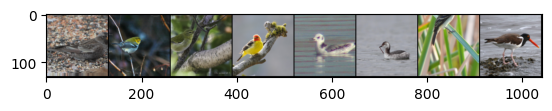

Labels:Black Rosy-Finch, Black-throated Green Warbler, Tennessee Warbler, Western Tanager (Breeding Male), Black-legged Kittiwake (Immature), Horned Grebe (Nonbreeding/juvenile), Least Flycatcher, American Oystercatcher


In [12]:
# dataiter = iter(data['train'])
# images, labels = dataiter.next()

# multi process
dataiter = iter(data['train'])
images, labels = next(dataiter)

images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [17]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [20]:
models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
effnet = mobilenet_v3_large(weights = MobileNet_V3_Large_Weights.DEFAULT)
effnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

losses = train(effnet, data['train'], epochs=2, lr=.1, print_every=100, checkpoint_path=checkpoints)

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
losses = train(resnet, data['train'], epochs=7, schedule={0:.01, 4:.001}, lr=.01, print_every=10, checkpoint_path=checkpoints, state=state)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.010000
Learning rate: 0.001000
[5,    10] loss: 1.155
[5,    20] loss: 1.092
[5,    30] loss: 1.089
[5,    40] loss: 0.988
[5,    50] loss: 1.011
[5,    60] loss: 1.013
[5,    70] loss: 1.008
[5,    80] loss: 0.959
[5,    90] loss: 0.904
[5,   100] loss: 1.000
[5,   110] loss: 0.921
[5,   120] loss: 0.940
[5,   130] loss: 0.969
[5,   140] loss: 0.976
[5,   150] loss: 0.944
[5,   160] loss: 0.994
[5,   170] loss: 0.919
[5,   180] loss: 0.964
[5,   190] loss: 0.930
[5,   200] loss: 0.919
[5,   210] loss: 0.915
[5,   220] loss: 0.951
[5,   230] loss: 0.959
[5,   240] loss: 0.908
[5,   250] loss: 0.873
[5,   260] loss: 0.927
[5,   270] loss: 0.909
[5,   280] loss: 0.914
[5,   290] loss: 0.922
[5,   300] loss: 0.875
[6,    10] loss: 0.860
[6,    20] loss: 0.891
[6,    30] loss: 0.907
[6,    40] loss: 0.831
[6,    50] loss: 0.894
[6,    60] loss: 0.857
[6,    70] loss: 0.871
[6,    80] loss: 0.851
[6,    90] loss: 0.819
[6,   100] loss: 0.933
[6,   110] loss: 0.771
[6,   120

KeyboardInterrupt: ignored

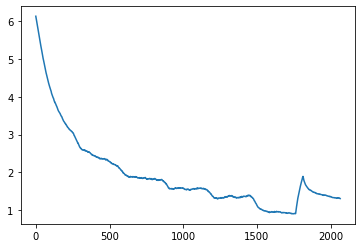

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

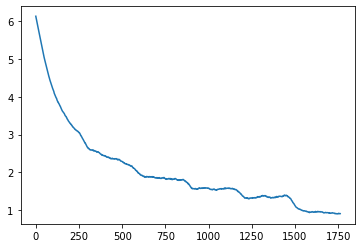

In [ ]:
state = torch.load(checkpoints + 'checkpoint-6.pkl')
plt.plot(smooth(state['losses'], 50))

In [ ]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-6.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "preds.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


## Experiments On May 27th

In [ ]:
# Bigger dataset
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256, padding=8, padding_mode='edge'), # Take 256x256 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
losses = train(resnet, data['train'], epochs=10, schedule={0:.01, 8:.001}, lr=.01, print_every=10, checkpoint_path=checkpoints, state=state)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.010000
[5,    10] loss: 2.194
[5,    20] loss: 1.788
[5,    30] loss: 1.640
[5,    40] loss: 1.571
[5,    50] loss: 1.460
[5,    60] loss: 1.403
[5,    70] loss: 1.317
[5,    80] loss: 1.382
[5,    90] loss: 1.389
[5,   100] loss: 1.285
[5,   110] loss: 1.326
[5,   120] loss: 1.280
[5,   130] loss: 1.257
[5,   140] loss: 1.260
[5,   150] loss: 1.192
[5,   160] loss: 1.254
[5,   170] loss: 1.260
[5,   180] loss: 1.234
[5,   190] loss: 1.188
[5,   200] loss: 1.124
[5,   210] loss: 1.199
[5,   220] loss: 1.186
[5,   230] loss: 1.145
[5,   240] loss: 1.160
[5,   250] loss: 1.172
[5,   260] loss: 1.153
[5,   270] loss: 1.151
[5,   280] loss: 1.152
[5,   290] loss: 1.072
[5,   300] loss: 1.111
[6,    10] loss: 0.942
[6,    20] loss: 0.958
[6,    30] loss: 0.926
[6,    40] loss: 0.988
[6,    50] loss: 0.971
[6,    60] loss: 0.935
[6,    70] loss: 0.964
[6,    80] loss: 0.978
[6,    90] loss: 0.941
[6,   100] loss: 0.947
[6,   110] loss: 0.956
[6,   120] loss: 0.893
[6,   130]

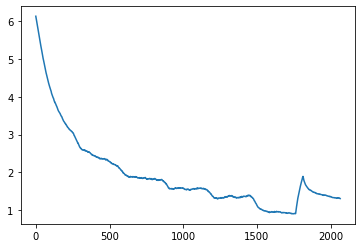

In [ ]:
state = torch.load(checkpoints + 'checkpoint-7.pkl')
plt.plot(smooth(state['losses'], 50))

In [ ]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-7.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "preds.csv")

NameError: ignored